In [2]:
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import tqdm

In [ ]:
mr_values = [5,10,15,20,25]
n = 10
patients = [patient for patient in os.listdir('.') if os.path.isdir(patient) and patient not in ["AX6281V","A36HR6Y","A7EM0B6","AZIK4ZA","AJ7TSV9"]]

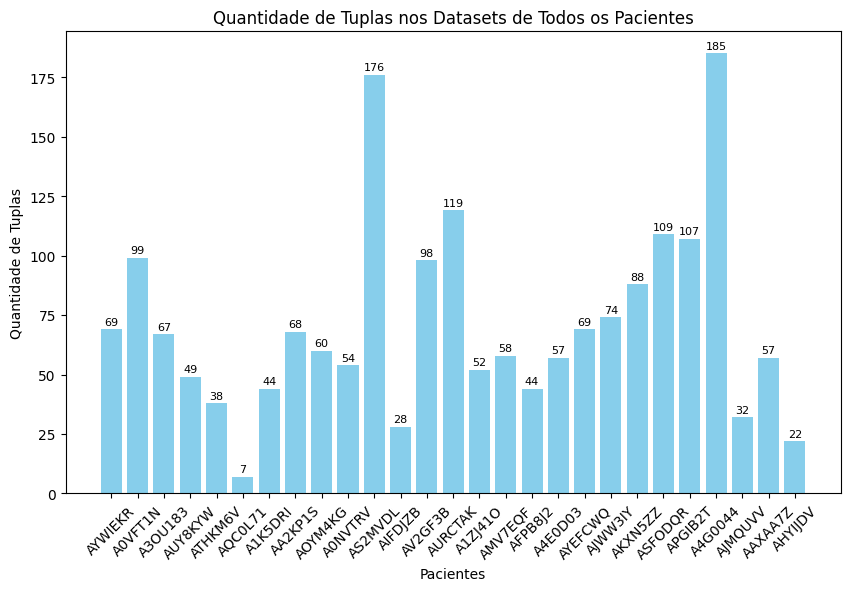

In [4]:
# Criar um dicionário para armazenar a quantidade de tuplas por paciente
tuples_count = {}

# Iterar sobre os pacientes e contar as tuplas no dataset completo (df_full)
for patient in patients:
    try:
        df_full = pd.read_csv(f'{patient}/Anomalies/{patient}_offline_anomalies.csv', usecols=[1, 2], header=None)
        tuples_count[patient] = len(df_full)
    except (FileNotFoundError, pd.errors.EmptyDataError):
        tuples_count[patient] = 0

# Plotar os resultados
plt.figure(figsize=(10, 6))
plt.bar(tuples_count.keys(), tuples_count.values(), color='skyblue')
plt.xlabel('Pacientes')
plt.ylabel('Quantidade de Tuplas')
plt.title('Quantidade de Tuplas nos Datasets de Todos os Pacientes')
plt.xticks(rotation=45)
# Adicionar os valores absolutos acima de cada barra
for i, (patient, count) in enumerate(tuples_count.items()):
    plt.text(i, count + 1, str(count), ha='center', va='bottom', fontsize=8)

plt.show()



## Patients Accumulated Metrics

In [1]:
def intervals_overlap(a, b):
    """Verifica se os intervalos a e b se sobrepõem"""
    return max(a[0], b[0]) <= min(a[1], b[1])

def match_event_intervals(y_true, y_pred):
    """
    Compara listas de intervalos (eventos reais e previstos).
    Cada intervalo é uma tupla: (inicio, fim)

    Retorna TP, FP, FN
    """
    matched = set()

    for i, pred in enumerate(y_pred):
        for j, true in enumerate(y_true):
            if intervals_overlap(pred, true):
                matched.add(j)
                break  # conta só uma correspondência

    TP = len(matched)
    FP = len(y_pred) - TP
    FN = len(y_true) - TP

    return TP, FP, FN

In [ ]:
metrics_table_mec = {mec: pd.DataFrame(columns=['MR', 'Accuracy', 'Precision', 'Recall', 'F1 Score']) for mec in ['MCAR', 'MAR', 'MNAR']}

for mec in ['MCAR','MAR','MNAR']:

    results = {}
    absolute = {}

    # Adicionar barra de progresso
    for patient in tqdm(patients, desc=f"Processando pacientes para {mec}"):
        # print(f"Processando paciente: {patient}")
        
        # Carregar df_full
        try:
            df_full = pd.read_csv(f'{patient}/Anomalies/{patient}_offline_anomalies.csv', usecols=[1, 2], header=None)
        except (FileNotFoundError, pd.errors.EmptyDataError):
            continue
        
        # Inicializar dfs_miss
        dfs_miss = {}
        for mr_value in mr_values:
            dfs_miss[mr_value] = {}
            for i in range(1, n + 1):
                file_path = f'{patient}/Anomalies/{mec}/{mr_value}/{patient}_offline_anomalies_{mec}_{mr_value}_{i}.csv'
                if os.path.exists(file_path) and os.path.getsize(file_path) > 0:
                    dfs_miss[mr_value][i] = pd.read_csv(file_path, usecols=[1, 2], header=None)
                else:
                    if not os.path.exists(file_path):
                        continue
                    elif os.path.getsize(file_path) == 0:
                        dfs_miss[mr_value][i] = pd.DataFrame(columns=[1, 2])  

        precision_list = {mr: [] for mr in mr_values}
        recall_list = {mr: [] for mr in mr_values}

        for mr, dfs in dfs_miss.items():
            for key, df_miss in dfs.items():
                y_true_intervals = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in zip(df_full[1], df_full[1])]
                y_pred_intervals = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in zip(df_miss[1], df_miss[1])]

                TP, FP, FN = match_event_intervals(y_true_intervals, y_pred_intervals)

                if mr not in absolute:
                    absolute[mr] = {'TP': [], 'FP': [], 'FN': []}
                absolute[mr]['TP'].append(TP)
                absolute[mr]['FP'].append(FP)
                absolute[mr]['FN'].append(FN)

                precision = TP / (TP + FP) if (TP + FP) > 0 else 0
                recall = TP / (TP + FN) if (TP + FN) > 0 else 0

                precision_list[mr].append(precision)
                recall_list[mr].append(recall)

        mean_precision_by_mr = {mr: [] for mr in mr_values}
        mean_recall_by_mr = {mr: [] for mr in mr_values}

        for mr in mr_values:
            precision_sum = sum(precision_list[mr])
            recall_sum = sum(recall_list[mr])
            count = len(precision_list[mr])

            mean_precision_by_mr[mr] = precision_sum / count if count > 0 else 0
            mean_recall_by_mr[mr] = recall_sum / count if count > 0 else 0

        for mr in mr_values:
            if mr not in results:
                results[mr] = {'precision': [], 'recall': []}
            results[mr]['precision'].append(mean_precision_by_mr[mr])
            results[mr]['recall'].append(mean_recall_by_mr[mr])

    # Inicializar os valores totais de TP, FP, FN
    # Inicializar os valores totais de TP, FP, FN por MR
    total_tp_by_mr = {mr: sum(values['TP']) for mr, values in absolute.items()}
    total_fp_by_mr = {mr: sum(values['FP']) for mr, values in absolute.items()}
    total_fn_by_mr = {mr: sum(values['FN']) for mr, values in absolute.items()}

    # Inicializar listas para armazenar as métricas
    accuracy_list = []
    precision_list = []
    f1_list = []
    recall_list = []

    # Calcular métricas para cada MR
    for mr in mr_values:
        tp = total_tp_by_mr[mr]
        fp = total_fp_by_mr[mr]
        fn = total_fn_by_mr[mr]
        total_instances = tp + fp + fn

        # Calcular acurácia, precisão, revocação e F1
        accuracy = tp / total_instances if total_instances > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        # Adicionar métricas às listas
        accuracy_list.append(accuracy * 100)
        precision_list.append(precision * 100)
        recall_list.append(recall * 100)
        f1_list.append(f1 * 100)

    # Criar um DataFrame com as métricas
    metrics_table = pd.DataFrame({
        'MR': mr_values,
        'Accuracy': accuracy_list,
        'Precision': precision_list,
        'Recall': recall_list,
        'F1 Score': f1_list
    })

    # Adicionar a tabela de métricas ao DataFrame geral
    metrics_table_mec[mec] = metrics_table

    # Exibir a tabela
    print(metrics_table)
        

Processando pacientes para MCAR:   0%|          | 0/27 [00:00<?, ?it/s]

Processando pacientes para MCAR: 100%|██████████| 27/27 [01:38<00:00,  3.65s/it]


   MR   Accuracy  Precision     Recall   F1 Score
0   5  79.692656  89.829968  87.595855  88.698846
1  10  69.200036  83.818172  79.870466  81.796715
2  15  60.249686  78.667648  72.015544  75.194763
3  20  52.229432  72.588011  65.062176  68.619361
4  25  45.045732  66.613276  58.181347  62.112454


Processando pacientes para MAR: 100%|██████████| 27/27 [01:31<00:00,  3.40s/it]


   MR   Accuracy  Precision     Recall   F1 Score
0   5  71.652094  86.500000  80.673575  83.485255
1  10  55.498060  76.789976  66.683938  71.381032
2  15  41.952614  66.472492  53.212435  59.107914
3  20  32.874494  60.059172  42.072539  49.482023
4  25  25.728155  53.989813  32.953368  40.926641


Processando pacientes para MNAR: 100%|██████████| 27/27 [01:45<00:00,  3.91s/it]

   MR   Accuracy  Precision     Recall   F1 Score
0   5  73.498262  77.711963  93.129534  84.725070
1  10  63.044898  70.901002  85.051813  77.334401
2  15  53.158549  66.070509  73.119171  69.416365
3  20  46.764672  63.833437  63.621762  63.727424
4  25  41.700421  62.676345  55.476684  58.857159


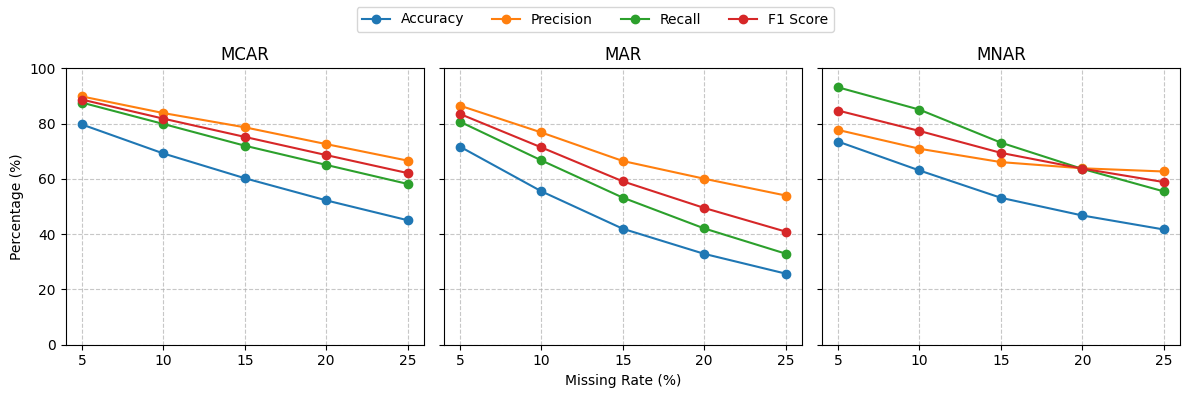

In [53]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

for idx, (mec_name, table) in enumerate(metrics_table_mec.items()):
    axs[idx].plot(table['MR'], table['Accuracy'], marker='o', label='Accuracy')
    axs[idx].plot(table['MR'], table['Precision'], marker='o', label='Precision')
    axs[idx].plot(table['MR'], table['Recall'], marker='o', label='Recall')
    axs[idx].plot(table['MR'], table['F1 Score'], marker='o', label='F1 Score')
    axs[idx].set_title(mec_name)
    axs[idx].set_ylim(0, 100)
    axs[idx].set_xticks(mr_values)
    if idx == 1:
        axs[idx].set_xlabel('Missing Rate (%)')
    axs[idx].set_ylabel('Percentage (%)' if idx == 0 else "")
    axs[idx].grid(True)

# Apenas uma legenda centralizada acima dos subplots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, fontsize=10)
for ax in axs:
    ax.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


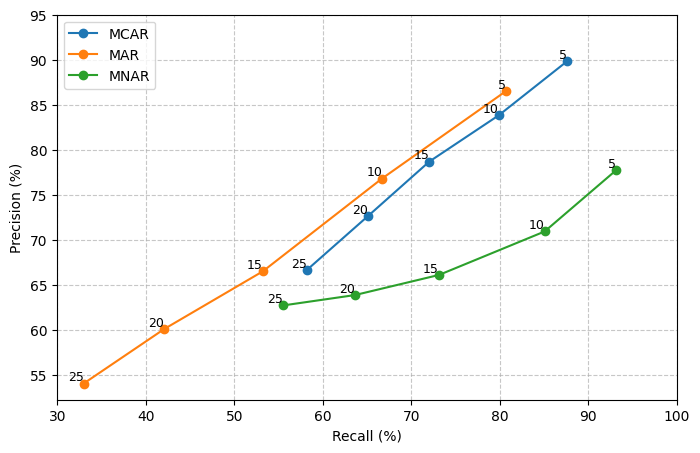

In [59]:
plt.figure(figsize=(8, 5))
for mec_name, table in metrics_table_mec.items():
    plt.plot(table['Recall'], table['Precision'], marker='o', label=mec_name)
    for i, row in table.iterrows():
        plt.text(row['Recall'], row['Precision'], f"{int(row['MR'])}", fontsize=9, ha='right', va='bottom')
plt.xlabel('Recall (%)')
plt.ylabel('Precision (%)')
plt.ylim(top=95)
plt.xlim(right=100)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper left')
plt.show()


## Patient Individual Metrics

In [60]:
# Calcular métricas de avaliação para cada paciente individualmente
patient_metrics = {}

for patient in patients:
    try:
        df_full = pd.read_csv(f'{patient}/Anomalies/{patient}_offline_anomalies.csv', usecols=[1, 2], header=None)
    except (FileNotFoundError, pd.errors.EmptyDataError):
        continue

    metrics_by_mec = {}
    for mec in ['MCAR', 'MAR', 'MNAR']:
        metrics_by_mr = []
        for mr in mr_values:
            tp_sum = fp_sum = fn_sum = 0
            count = 0
            for i in range(1, n + 1):
                file_path = f'{patient}/Anomalies/{mec}/{mr}/{patient}_offline_anomalies_{mec}_{mr}_{i}.csv'
                if not os.path.exists(file_path) or os.path.getsize(file_path) == 0:
                    continue
                try:
                    df_miss = pd.read_csv(file_path, usecols=[1, 2], header=None)
                except pd.errors.EmptyDataError:
                    continue

                y_true_intervals = [(pd.to_datetime(start), pd.to_datetime(start)) for start in df_full[1]]
                y_pred_intervals = [(pd.to_datetime(start), pd.to_datetime(start)) for start in df_miss[1]]

                TP, FP, FN = match_event_intervals(y_true_intervals, y_pred_intervals)
                tp_sum += TP
                fp_sum += FP
                fn_sum += FN
                count += 1

            if count > 0:
                accuracy = tp_sum / (tp_sum + fp_sum + fn_sum) if (tp_sum + fp_sum + fn_sum) > 0 else 0
                precision = tp_sum / (tp_sum + fp_sum) if (tp_sum + fp_sum) > 0 else 0
                recall = tp_sum / (tp_sum + fn_sum) if (tp_sum + fn_sum) > 0 else 0
                f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            else:
                accuracy = precision = recall = f1 = 0

            metrics_by_mr.append({
                'MR': mr,
                'Accuracy': accuracy * 100,
                'Precision': precision * 100,
                'Recall': recall * 100,
                'F1 Score': f1 * 100
            })
        metrics_by_mec[mec] = pd.DataFrame(metrics_by_mr)
    patient_metrics[patient] = metrics_by_mec


In [95]:
# Transformar o dicionário patient_metrics em um único DataFrame
records = []
for patient, mec_dict in patient_metrics.items():
    for mec, df in mec_dict.items():
        for _, row in df.iterrows():
            records.append({
                'Patient': patient,
                'MEC': mec,
                'MR': row['MR'],
                'Accuracy': row['Accuracy'],
                'Precision': row['Precision'],
                'Recall': row['Recall'],
                'F1 Score': row['F1 Score']
            })

patient_metrics_df = pd.DataFrame(records)
patient_metrics_df.head()

,Patient,MEC,MR,Accuracy,Precision,Recall,F1 Score
0,AYWIEKR,MCAR,5.0,69.818653,86.795491,78.115942,82.227307
1,AYWIEKR,MCAR,10.0,57.806913,76.498423,70.289855,73.262840
2,AYWIEKR,MCAR,15.0,54.447115,76.134454,65.652174,70.505837
3,AYWIEKR,MCAR,20.0,50.000000,67.713004,65.652174,66.666667
4,AYWIEKR,MCAR,25.0,43.514644,60.997067,60.289855,60.641399


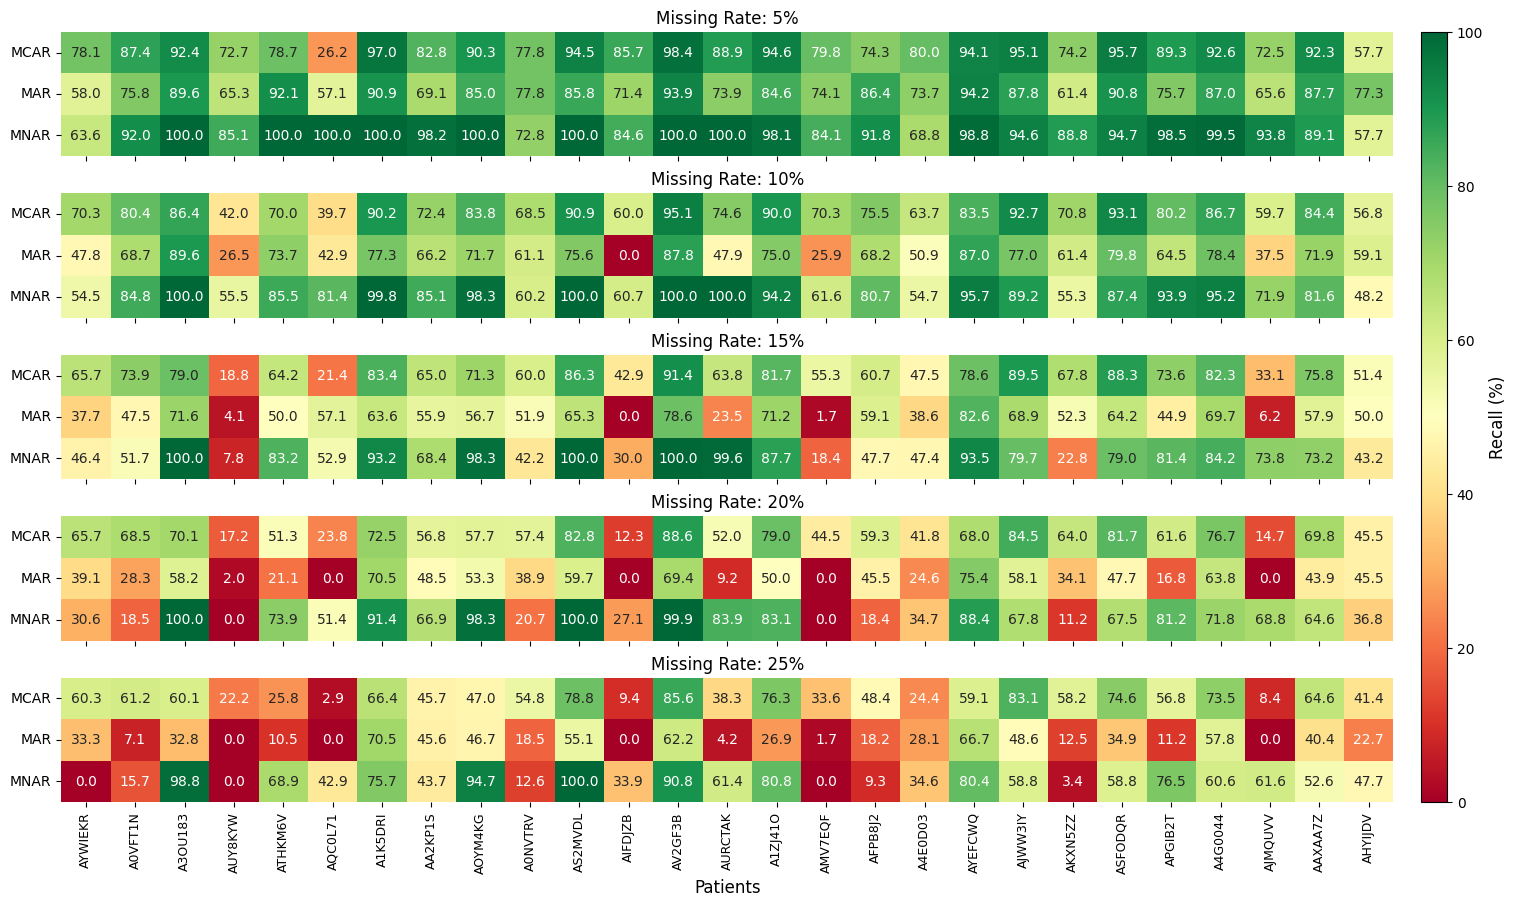

In [125]:
metric = 'Recall'  # Escolha a métrica para o heatmap

mec_order = ['MCAR', 'MAR', 'MNAR']
patient_metrics_df['MEC'] = pd.Categorical(patient_metrics_df['MEC'], categories=mec_order, ordered=True)

heatmap_data = {}
for mr in mr_values:
    df_pivot = patient_metrics_df[patient_metrics_df['MR'] == mr].pivot(index='MEC', columns='Patient', values=metric)
    df_pivot = df_pivot[patients]
    heatmap_data[mr] = df_pivot

# Criar os heatmaps empilhados verticalmente, um para cada MR, eixo y = MEC
fig, axes = plt.subplots(len(mr_values), 1, figsize=(18, 10), sharex=True, sharey=True, gridspec_kw={'hspace': 0.3})

vmin = min(df.min().min() for df in heatmap_data.values())
vmax = max(df.max().max() for df in heatmap_data.values())

for ax, (mr, df) in zip(axes, heatmap_data.items()):
    sns.heatmap(df, ax=ax, cmap='RdYlGn', vmin=vmin, vmax=vmax, cbar=False, annot=True, fmt=".1f")
    ax.set_title(f'Missing Rate: {mr}%', fontsize=12)
    ax.set_ylabel('', fontsize=12)
    ax.set_xlabel('')  
    if ax == axes[-1]:
        ax.set_xlabel('Patients', fontsize=12)
    ax.set_yticklabels(df.index, rotation=0)
    ax.set_xticklabels(df.columns, rotation=90, fontsize=9)

cbar = fig.colorbar(
    axes[0].collections[0],
    ax=axes,
    orientation='vertical',
    fraction=0.025,
    pad=0.02,
    aspect=30
)
cbar.set_label(f'{metric} (%)', fontsize=12)

plt.show()